# Research Paper

### A Data Analysis of Severe Storms and Temperature Data over the California Region. 

In [1]:
import os
os.chdir('/Users/achav/climatemath/data/data')

In [10]:
import numpy as np 
import pandas as pd
import warnings
import math as m
import netCDF4 as nc
from netCDF4 import Dataset

import matplotlib
import matplotlib.dates as mdates
from matplotlib import cm as cm1
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta

from scipy import optimize as opt
from sklearn.linear_model import LinearRegression
import time
warnings.filterwarnings("ignore")

In [5]:
#read the nc file
datamat = Dataset('air.mon.mean1.nc')
datamat

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description:  Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces.
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Mon Jul  5 21:45:36 1999: ncrcat air.mon.mean.nc /Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Tue Oct 17 20:07:08 1995 from air.85.nc
created 95/02/06 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    dimensions(sizes): level(17), lat(73), lon(144), time(927)
    variables(dimensions): float32 level(level), float32 lat(lat), float32 lon(lon), float64 time(time), floa

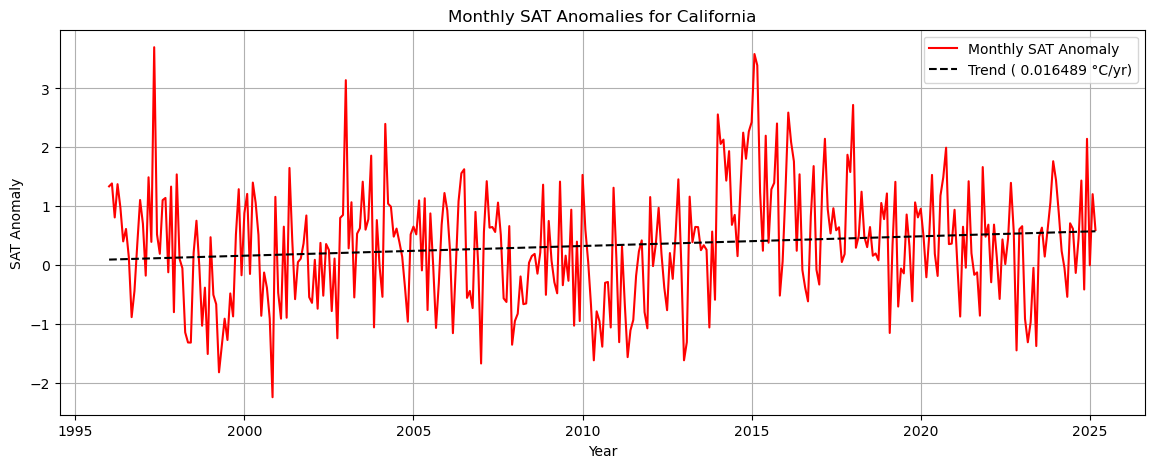

In [11]:
#getting the variables from the nc file
time = datamat.variables['time'][:]
lat = datamat.variables['lat'][:]
lon = datamat.variables['lon'][:]
air = datamat.variables['air'][:]

level_index = 0

#convert time
base = datetime(1800, 1, 1)
convert_time = np.array([base + timedelta(hours=float(h)) for h in time])

#adjusting longitude
if np.max(lon) > 180:
    lon = np.where(lon > 180, lon - 360, lon)
    
#getting California coordinate bounds
lat_index = np.where((lat >= 30) & (lat <= 43))[0]
lon_index = np.where((lon >= -130) & (lon <= -111))[0]

#extracting the sat
sat = air[:, level_index, lat_index.min():lat_index.max()+1, lon_index.min():lon_index.max()+1]

#monthly mean for California
monthly_mean = np.mean(sat, axis=(1,2))

#computing the climatology
months = np.array([t.month for t in convert_time])
clim = np.array([monthly_mean[months == m].mean() for m in range(1, 13)])

#computing the anomalies
anom = monthly_mean - clim[months - 1]

#convert years to decimals
y_decimal = np.array([t.year + (t.month - 1) / 12 for t in convert_time])

#filter from 1995 to present
start = 1996
time_df = y_decimal >= start
y_decimal = y_decimal[time_df]
anom = anom[time_df]

#linear regression
x = y_decimal.reshape(-1,1)
y = anom
lm = LinearRegression()
lm.fit(x,y)
trend = lm.predict(x)
slope = lm.coef_[0]
intercept = lm.intercept_

#plot
plt.figure(figsize=(14,5))
plt.plot(y_decimal, anom, label='Monthly SAT Anomaly', color = 'red')
plt.plot(y_decimal, trend, label=f'Trend ({slope: 3f} °C/yr)', color = 'black', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('SAT Anomaly')
plt.title("Monthly SAT Anomalies for California")
plt.grid(True)
plt.legend()
plt.show()


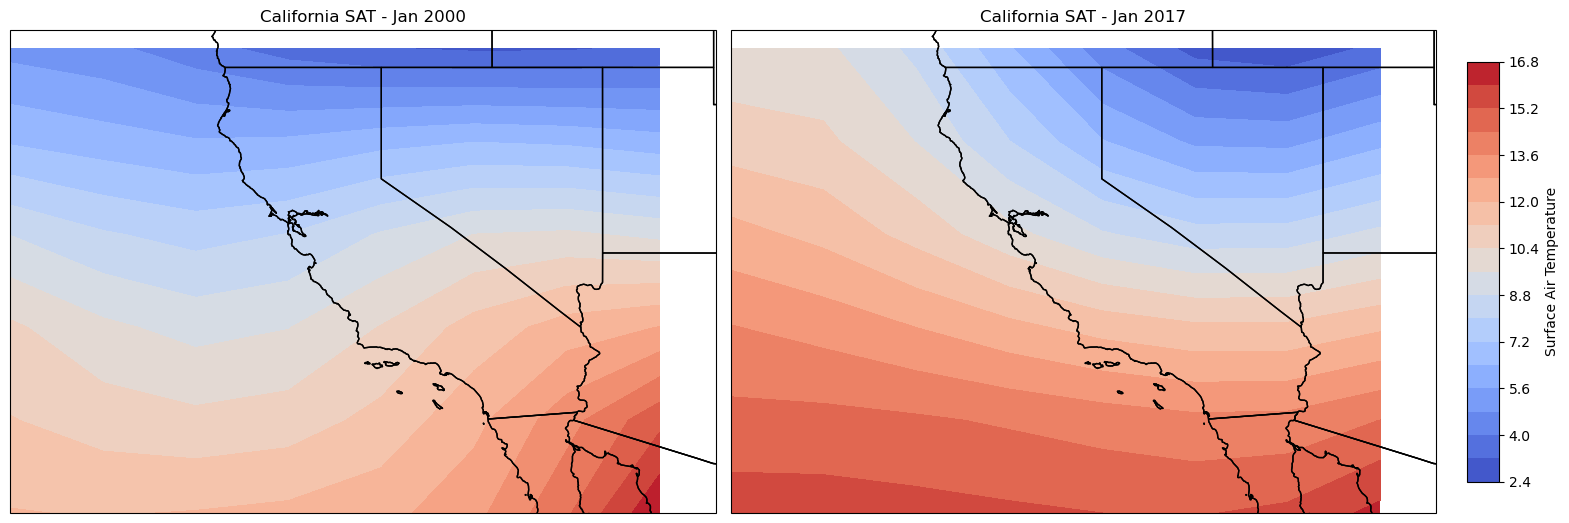

In [15]:
#extracing january data
jan2000 = [i for i, t in enumerate(convert_time) if t.year == 2000 and t.month == 1]
jan2017 = [i for i, t in enumerate(convert_time) if t.year == 2017 and t.month == 1]

jan2000_sat = np.mean(sat[jan2000, :, :], axis=0)
jan2017_sat = np.mean(sat[jan2017, :, :], axis=0)

lat1 = lat[lat_index.min():lat_index.max()+1]
lon1 = lon[lon_index.min():lon_index.max()+1]
Lon, Lat = np.meshgrid(lon1, lat1)

#plot
fig, axs = plt.subplots(1,2, figsize=(16,6), subplot_kw={'projection': ccrs.PlateCarree()})

#January 2000 contour map
cont1 = axs[0].contourf(Lon, Lat, jan2000_sat, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())
axs[0].set_title("California SAT - Jan 2000")
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS)
axs[0].add_feature(cfeature.STATES)
axs[0].set_extent([-130, -111, 30, 43])

#January 2017 contour map
cont2 = axs[1].contourf(Lon, Lat, jan2017_sat, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())
axs[1].set_title("California SAT - Jan 2017")
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS)
axs[1].add_feature(cfeature.STATES)
axs[1].set_extent([-130, -111, 30, 43])

#colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(cont2, cax=cbar_ax, label='Surface Air Temperature')

plt.tight_layout(rect=[0, 0, 0.91, 1])
plt.show()

In [20]:
#read the nc file
precip = Dataset('prate.sfc.gauss.2017.nc')
temp = Dataset('air.2m.gauss.2017.nc')

#precip
temp

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: mean daily NMC reanalysis (2014)
    history: created 2013/12 by Hoop (netCDF2.3)
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    dataset_title: NCEP-NCAR Reanalysis 1
    References: https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.html
    dimensions(sizes): lat(94), lon(192), time(365), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 air(time, lat, lon), float64 time_bnds(time, nbnds)
    groups: 

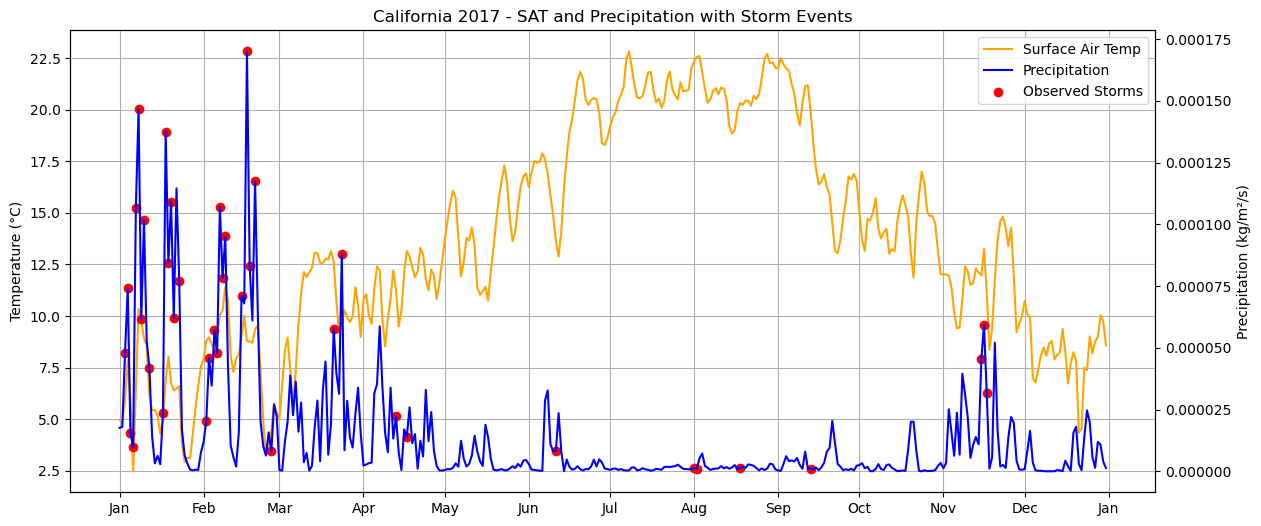

In [31]:
#get variables
lat = precip.variables['lat'][:]
lon = precip.variables['lon'][:]
time = precip.variables['time'][:]

#convert the time
base = datetime(1800, 1, 1)
dates = np.array([base + timedelta(hours=float(h)) for h in time])

precip2017 = precip.variables['prate'][:]
temp2017 = temp.variables['air'][:] - 273.15 #convert to celsius

#adjusting longitude
if np.max(lon) > 180:
    lon = np.where(lon > 180, lon - 360, lon)
    
#California coordinate bounds
lat_idx = np.where((lat >= 30) & (lat <= 43))[0]
lon_idx = np.where((lon >= -130) & (lon <= -111))[0]

#taking the average
precip_ca = precip2017[:, lat_idx, :][:, :, lon_idx]
temp_ca = temp2017[:, lat_idx, :][:, :, lon_idx]
precip_avg = np.mean(precip_ca, axis=(1,2))
temp_avg = np.mean(temp_ca, axis=(1,2))

#read the csv file
storm_df = pd.read_csv('California storms 2015-2017.csv')
storm_df['BEGIN_DATE'] = pd.to_datetime(storm_df['BEGIN_DATE'], errors='coerce')

#filter for 2017 storm dates
storm_date17 = set(storm_df.loc[storm_df['BEGIN_DATE'].dt.year == 2017, 'BEGIN_DATE'].dt.date)
storm_idx = [i for i, d in enumerate(dates) if d.date() in storm_date17]

#plot
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_title('California 2017 - SAT and Precipitation with Storm Events')

#Temperature plot
ax1.plot(dates, temp_avg, color='orange', label='Surface Air Temp')
ax1.set_ylabel('Temperature (°C)')
ax1.tick_params(axis='y')
ax1.grid(True)

#Precipitation plot
ax2 = ax1.twinx()
ax2.plot(dates, precip_avg, color='blue', label='Precipitation')
ax2.scatter(np.array(dates)[storm_idx], precip_avg[storm_idx], color='red', label='Observed Storms')
ax2.set_ylabel('Precipitation (kg/m²/s)')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

#format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlabel('Month')
plt.show()



In [37]:
#read the nc file
precip1 = Dataset('prate.sfc.gauss.2000.nc')
temp1 = Dataset('air.2m.gauss.2000.nc')

#precip
temp1

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: mean daily NMC reanalysis (2000)
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    history: created 00/01/30 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.html
    dimensions(sizes): lon(192), lat(94), time(366), nbnds(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 air(time, lat, lon), float64 time_bnds(time, nbnds)
    groups: 

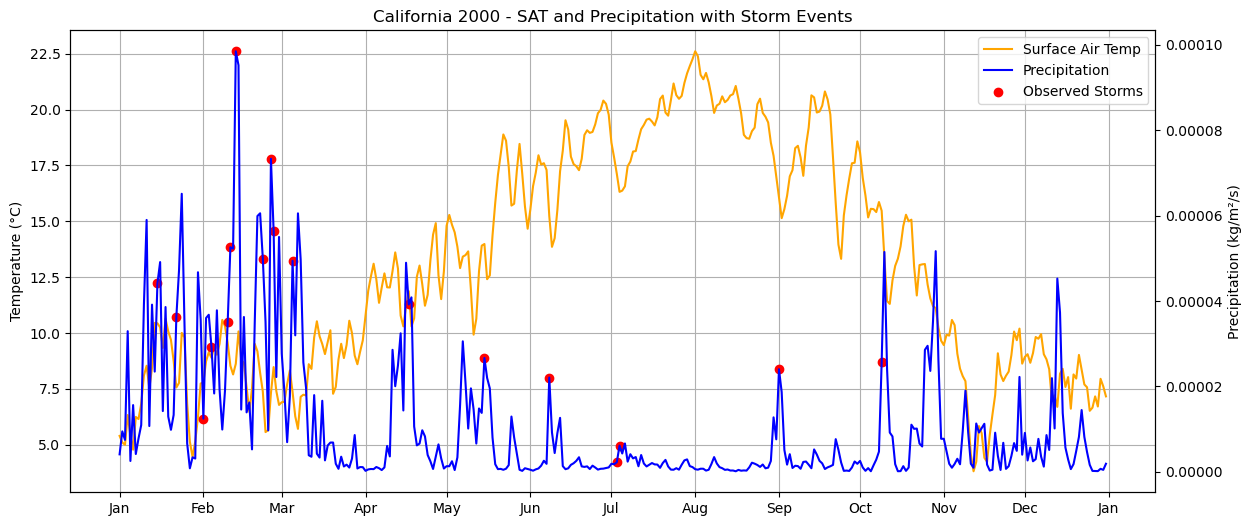

In [36]:
#get the variables
lat = precip1.variables['lat'][:]
lon = precip1.variables['lon'][:]
time = precip1.variables['time'][:]

#convert the time
base1 = datetime(1800, 1, 1)
dates1 = np.array([base + timedelta(hours=float(h)) for h in time])

precip2000 = precip1.variables['prate'][:]
temp2000 = temp1.variables['air'][:] - 273.15 #convert to celsius

#adjusting longitude
if np.max(lon) > 180:
    lon = np.where(lon > 180, lon - 360, lon)
    
#California coordinate bounds
lat_idx = np.where((lat >= 30) & (lat <= 43))[0]
lon_idx = np.where((lon >= -130) & (lon <= -111))[0]

#taking the average
precip_ca1 = precip2000[:, lat_idx, :][:, :, lon_idx]
temp_ca1 = temp2000[:, lat_idx, :][:, :, lon_idx]
precip_avg1 = np.mean(precip_ca1, axis=(1,2))
temp_avg1 = np.mean(temp_ca1, axis=(1,2))

#read the csv file
storms = pd.read_csv('California storms 1999-2001.csv')
storms['BEGIN_DATE'] = pd.to_datetime(storms['BEGIN_DATE'], errors='coerce')

#filter for 2000 storm dates
storm_date00 = set(storms.loc[storms['BEGIN_DATE'].dt.year == 2000, 'BEGIN_DATE'].dt.date)
storms_idx = [i for i, d in enumerate(dates1) if d.date() in storm_date00]

#plot
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_title('California 2000 - SAT and Precipitation with Storm Events')

#Temperature plot
ax1.plot(dates1, temp_avg1, color='orange', label='Surface Air Temp')
ax1.set_ylabel('Temperature (°C)')
ax1.tick_params(axis='y')
ax1.grid(True)

#Precipitation plot
ax2 = ax1.twinx()
ax2.plot(dates1, precip_avg1, color='blue', label='Precipitation')
ax2.scatter(np.array(dates1)[storms_idx], precip_avg1[storms_idx], color='red', label='Observed Storms')
ax2.set_ylabel('Precipitation (kg/m²/s)')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

#format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlabel('Month')
plt.show()

